# Jackknife vs. Mode Counting for a Full Sky map

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy  as np
import healpy as hp
from time import time
from utils import split_jackknife, split_jackknife_new, hpix2radec, clerr_jack

camb is not installed!


# Measure the C_ell
The code takes mask and weight arrays, I'll pass ones.

In [9]:
def jkmasks(mask, weight, njack=4):
    '''
    Function that makes Jackknife masks
    
    
    example
    --------
    >>> jkmasks_dic = jkmasks(mask_1, weight_1)
    >>> for k in jkmasks_dic:
    ...     hp.mollview(jkmasks_dic[k], title=k)
    
    '''
    assert mask.size == weight.size
    
    nside = hp.get_nside(mask)
    
    # --- make jackknife samples
    hpix_jk,_ = split_jackknife_new(np.argwhere(mask).flatten(),
                                    weight[mask], 
                                    njack=njack)
    masks_dic = {-1:mask}
    for jackid in range(njack):
        mask_tmp = mask.copy()
        mask_tmp[hpix_jk[jackid]] = False
        masks_dic[jackid] = mask_tmp
        
    return masks_dic


class AnaFast:
    '''
    
    examples
    --------
    # credit: Mehdi Rezaie
    >>> #--- create mock C_ell
    >>> ell_true = np.arange(1024)
    >>> cl_true = 1.e-6*(0.001+ell_true)/(1+ell_true*ell_true)
    >>> map1 = hp.synfast(cl_true, nside=256, new=True)

    >>> #--- create a mock window, e.g., half the sky
    >>> mask_1 = np.ones_like(map1, '?')
    >>> weight_1 = np.ones_like(map1)
    >>> mask_p5 = mask_1.copy()
    >>> mask_p5[mask_1.size//2:] = False

    >>> #--- run AnaFast with Jackknife
    >>> af = AnaFast()
    >>> output = af(map1, weight_1, mask_p5, lmax=512, njack=20)

    >>> #--- plot
    >>> fig, ax = plt.subplots()
    >>> ax.loglog(output['ell'], output['Cell'], 
    ...           c='crimson', label='Measured')
    >>> for cli in af.jkcells:
    ...    ax.loglog(af.jkcells[cli], color='grey', zorder=-1, alpha=0.2)

    >>> ax.loglog(cl_true, 'k', label='True')
    >>> ax.legend(fontsize=12)
    >>> ax.grid(True, ls=':', which='both', alpha=0.2)
    >>> ax.set(xlabel=r'$\ell$', ylabel=r'C$_\ell$', ylim=(1.0e-9, 2.0e-6))
    
    '''
    def __init__(self):          
        pass
    
    def __call__(self, map1, weight1, mask1, 
                 map2=None, weight2=None, mask2=None, 
                 lmax=None, njack=0):
        
        print(f'lmax: {lmax}')
        print(f'njack: {njack}')
        
        if njack == 0:
            cl_auto = self.run(map1, weight1, mask1, 
                                 map2=map2, weight2=weight2, mask2=mask2, 
                                 lmax=lmax)
            
            output = {'ell':np.arange(cl_auto.size),
                       'Cell':cl_auto,
                       'Cell_error':np.nan,
                       'njack':njack, 
                       'lmax':lmax}
            
        elif njack > 1:            
            self.run_w_jack(map1, weight1, mask1, 
                             map2=map2, weight2=weight2, mask2=mask2, 
                             lmax=lmax, njack=njack)
            
            output = {'ell':np.arange(self.jkcells[-1].size),
                       'Cell':self.jkcells[-1],
                      'Cell_error':self.clstd,
                      'njack':njack,
                      'lmax':lmax,
                      'Celljk':self.jkcells}
        else:                 
            raise RuntimeError(f'njack: {njack} must be > 1 or == 0')
        
        return output
    
    def run_w_jack(self, map1, weight1, mask1, 
                   map2=None, weight2=None, mask2=None, 
                   lmax=None, njack=4):
        
        #print(f'njack: {njack}')
        
        #--- split the common mask into N Jackknifes        
        mask_common = mask1.copy()        
        if mask2 is not None:            
            mask_common &= mask2   
        self.jkmasks_dic = jkmasks(mask_common, weight1, njack=njack)
        
        #--- compute the mean
        self.jkcells = {}
        for k in self.jkmasks_dic:
            t0 = time()
            self.jkcells[k] = self.run(map1, weight1, self.jkmasks_dic[k],
                                  map2=map2, weight2=weight2, mask2=self.jkmasks_dic[k],
                                  lmax=lmax)
            if k==0:print(f'{k}, {time()-t0:.2f} secs')
        
        #--- compute the dispersion
        clvar = np.zeros_like(self.jkcells[-1])
        for i in range(njack):
            res = (self.jkcells[-1] - self.jkcells[i])
            clvar += res*res
        clvar *= (njack-1)/njack        
        self.clstd = np.sqrt(clvar)
        
        
    def run(self, map1, weight1, mask1, 
            map2=None, weight2=None, mask2=None, lmax=None):
        
        mask_common = mask1.copy()

        if (map2 is not None) & (weight2 is not None) & (mask2 is not None):
            
            mask_common &= mask2   
            #weight2 /= np.mean(weight2[mask_common])
            
            hp_map2 = hp.ma(map2 * weight2)
            hp_map2.mask = np.logical_not(mask_common)
            hp_map2 = hp_map2.filled()

        else:
            hp_map2 = None
        
        #weight1 /= np.mean(weight1[mask_common])
        
        hp_map1 = hp.ma(map1 * weight1)
        hp_map1.mask = np.logical_not(mask_common)
        hp_map1 = hp_map1.filled()        
        normalization = np.mean(mask_common)
        
#         map_i  = hp.ma(mask_common.astype('f8')) 
#         map_i.mask = np.logical_not(mask_common) 
#         clmask = hp.anafast(map_i.filled())
#         sf = ((2*np.arange(clmask.size)+1)*clmask).sum()/(4.*np.pi)
        
        #print(sf, normalization)
        return hp.anafast(hp_map1, map2=hp_map2, lmax=lmax)/normalization

In [3]:
ngal = hp.read_map('/Volumes/TimeMachine/data/DR7/eBOSS.ELG.NGC.DR7.cut.hp256.fits')
mask = hp.read_map('/Volumes/TimeMachine/data/DR7/mask.cut.hp.256.fits') > 0
frac = hp.read_map('/Volumes/TimeMachine/data/DR7/frac.hp.256.fits')

NSIDE = 256
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 256
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 256
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


In [4]:
from utils import makedelta 

In [5]:
import fitsio as ft

In [6]:
delta = makedelta(ngal, frac, mask)

In [7]:
templates = ft.read('/Volumes/TimeMachine/data/DR7/eBOSS.ELG.NGC.DR7.table.fits')
sysematics = []
for tm in range(18):
    print('.', end='')
    mapi = np.zeros(12*256*256)
    mapi[templates['hpind']] = templates['features'][:, tm]
    sysematics.append(makedelta(mapi, frac, mask, is_sys=True))

..................

In [11]:
clgs = []
clss = []

# auto
AFauto = AnaFast()
AFcross = AnaFast()

clgg = AFauto(delta, frac, mask, njack=20, lmax=512)
for i in range(18):
    print('.', end='')
    clss.append(AFauto(sysematics[i], frac, mask, njack=20, lmax=512))
    clgs.append(AFcross(delta, frac, mask, njack=20, lmax=512, 
                        map2=sysematics[i], weight2=frac, mask2=mask))
    
    

lmax: 512
njack: 20
0, 0.44 secs
.lmax: 512
njack: 20
0, 0.45 secs
lmax: 512
njack: 20
0, 0.89 secs
.lmax: 512
njack: 20
0, 0.45 secs
lmax: 512
njack: 20
0, 0.90 secs
.lmax: 512
njack: 20
0, 0.45 secs
lmax: 512
njack: 20
0, 0.89 secs
.lmax: 512
njack: 20
0, 0.46 secs
lmax: 512
njack: 20
0, 0.89 secs
.lmax: 512
njack: 20
0, 0.45 secs
lmax: 512
njack: 20
0, 0.89 secs
.lmax: 512
njack: 20
0, 0.45 secs
lmax: 512
njack: 20
0, 0.89 secs
.lmax: 512
njack: 20
0, 0.45 secs
lmax: 512
njack: 20
0, 0.89 secs
.lmax: 512
njack: 20
0, 0.45 secs
lmax: 512
njack: 20
0, 0.89 secs
.lmax: 512
njack: 20
0, 0.45 secs
lmax: 512
njack: 20
0, 0.89 secs
.lmax: 512
njack: 20
0, 0.45 secs
lmax: 512
njack: 20
0, 0.89 secs
.lmax: 512
njack: 20
0, 0.45 secs
lmax: 512
njack: 20
0, 0.89 secs
.lmax: 512
njack: 20
0, 0.45 secs
lmax: 512
njack: 20
0, 0.89 secs
.lmax: 512
njack: 20
0, 0.45 secs
lmax: 512
njack: 20
0, 0.89 secs
.lmax: 512
njack: 20
0, 0.45 secs
lmax: 512
njack: 20
0, 0.90 secs
.lmax: 512
njack: 20
0, 0.45 

In [12]:
np.save('/Volumes/TimeMachine/data/DR7/results_referee/cl_uni_dr7_gg_ss_sg.npy',
       [clgg, clgs, clss])

In [13]:
cldr7_org = np.load('/Volumes/TimeMachine/data/DR7/results/clustering/cl_uni.npy', allow_pickle=True).item()
cldr7_org.keys()

dict_keys(['cross', 'auto', 'clerr', 'clabels', 'sf'])

(1e-06, 0.01)

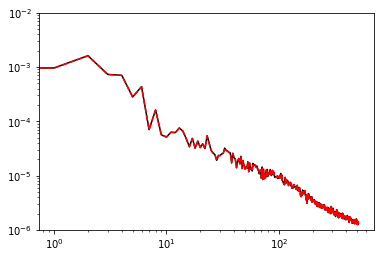

In [14]:
plt.loglog(cldr7_org['auto'], 'k', 
         clgg['Cell'], 'r--')
plt.ylim(1.e-6, 1.e-2)
# plt.plot([0., 0.0016], [0., 0.0016])

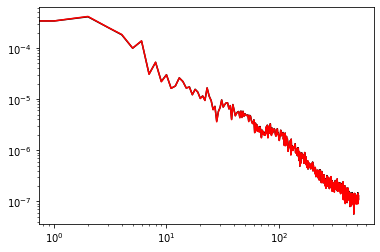

In [15]:
plt.loglog(cldr7_org['clerr']['clerr'], 'k', 
             clgg['Cell_error'], 'r-')

In [17]:
clgg['Celljk'].keys()

dict_keys([-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19])

In [19]:
clgs[0].keys()

dict_keys(['ell', 'Cell', 'Cell_error', 'njack', 'lmax', 'Celljk'])

In [27]:
from utils import binit

In [28]:
ell = np.arange(513)

sig_cross = []

for j in range(18):
    print(j, end=' ')
    
    clcross = {}

    for k in range(-1, 20):
        _,clgs_i = binit(ell, clgs[j]['Celljk'][k])
        _, clss_i = binit(ell, clss[j]['Celljk'][k])
        clcross[k] =  clgs_i**2 /clss_i 


    #--- compute the dispersion
    clvar = np.zeros(9)

    njack = 20
    for i in range(njack):
        res = (clcross[-1] - clcross[i])
        clvar += res*res
    clvar *= (njack-1)/njack        
    
    
    sig_cross.append(np.sqrt(clvar))

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 

In [29]:
np.save('/Volumes/TimeMachine/data/DR7/results_referee/cl_uni_dr7_sig_sg2_ss.npy',
       sig_cross)

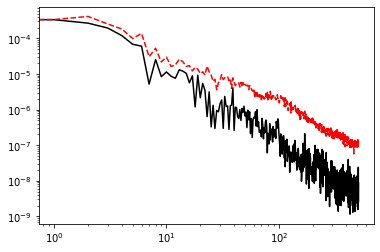

In [26]:
plt.loglog(sig_cross[0], 'k-',
        clgg['Cell_error'], 'r--')